In [24]:
%run runaway_functionsv3

In [18]:
for cluster in workclusters3d[:]:
    # print("-"*50)
    # print(cluster)
    # print("-"*50)
    Cluster(cluster).prepare_trace3d()

./traceback ../../cluster_runaway3d/ASCC_107/ASCC_107_trace.conf
./traceback ../../cluster_runaway3d/ASCC_114/ASCC_114_trace.conf
./traceback ../../cluster_runaway3d/ASCC_127/ASCC_127_trace.conf
./traceback ../../cluster_runaway3d/ASCC_13/ASCC_13_trace.conf
./traceback ../../cluster_runaway3d/ASCC_16/ASCC_16_trace.conf
./traceback ../../cluster_runaway3d/ASCC_19/ASCC_19_trace.conf
./traceback ../../cluster_runaway3d/ASCC_21/ASCC_21_trace.conf
./traceback ../../cluster_runaway3d/ASCC_32/ASCC_32_trace.conf
./traceback ../../cluster_runaway3d/Alessi_20/Alessi_20_trace.conf
./traceback ../../cluster_runaway3d/Alessi_43/Alessi_43_trace.conf
./traceback ../../cluster_runaway3d/Alessi_Teutsch_5/Alessi_Teutsch_5_trace.conf
./traceback ../../cluster_runaway3d/Archinal_1/Archinal_1_trace.conf
./traceback ../../cluster_runaway3d/Aveni_Hunter_1/Aveni_Hunter_1_trace.conf
./traceback ../../cluster_runaway3d/BDSB91/BDSB91_trace.conf
./traceback ../../cluster_runaway3d/BDSB93/BDSB93_trace.conf
./trace

In [25]:
cl = Cluster("Basel_8")

cl.runaways_all()

getting from /home/surodeep/suro_aiu/traceback/cluster_runaway3d/


RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,e_rmRA,e_rmDE,rRV,e_rRV,v_pec,v_pec3d,e_vpec,e_vpec3d
deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s,km / s,km / s,km / s,km / s
float64,float64,float64,float64,float64,int32,str10,int64,float64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,str1,str1,float64,float32,float32,float32,SkyCoord,float64,float64,float32,float32,float64,float32,float64,float64,float64,float64
98.38429327278,8.33557580226,0.0298,0.0279,20.6218,--,733-1218-1,3326048448124872320,1517.70947000,0.6283,0.0363,-0.760,-1.057,0.035,0.028,1.363,32036.6,3.9984,8.432107,0.337074,8.528219,8.191145,67.90,17.90,1442.38904000,1621.94727000,7981856.09929,1.935e+04,5.298e+06,4.473e+04,4.195e+06,3.635e+04,--,--,0.00381,0.009581,0.01014,0.01972,"98.38429327278,8.33557580226,1517.70947",-0.5703750050067902,1.1261250190734864,0.2598477,0.2528477,--,--,9.081153222849567,--,2.3092690045811937,--
98.69055275937,8.07569472560,0.0356,0.0302,8.1797,--,733-1687-1,3326026144355977472,1458.14001000,0.6601,0.0421,-1.403,0.651,0.039,0.031,1.529,--,--,9.317637,0.329390,9.419267,9.089877,27.80,3.40,1378.07080000,1536.19507000,3530953.30802,1620,2.332e+06,5770,1.833e+06,2216,--,--,0.0028,0.003873,0.004001,0.007874,"98.69055275937,8.0756947256,1458.14001",-1.2133750050067902,2.834125019073486,0.26384768,0.2558477,--,--,21.30802513378318,--,5.478361559307416,--
98.55031962528,7.98752507297,0.0259,0.0256,3.0701,--,733-1512-1,3326023842254469120,1409.47327000,0.6747,0.0338,-0.049,-2.251,0.033,0.026,1.305,11353.8,3.4433,9.743308,0.202579,9.800635,9.598057,20.90,4.80,1354.19275000,1463.96838000,2385742.02510,856.2,1.641e+06,1297,1.148e+06,614.7,--,--,0.002783,0.002919,0.003824,0.006743,"98.55031962528,7.98752507297,1409.47327",0.14062499499320985,-0.06787498092651356,0.2578477,0.2508477,-0.05,15.58,1.0432140600484652,1.04,0.26762581622056764,0.79
98.80943694927,8.02405631161,0.0143,0.0132,14.9497,--,733-1827-1,3325977426545923840,1605.87500000,0.6013,0.0165,2.491,-3.233,0.018,0.016,0.950,--,--,11.189508,1.873466,12.116813,10.243346,54.60,0.20,1569.39270000,1654.23608000,629714.19999,137.1,1.944e+05,153.6,6.336e+05,217.9,--,--,0.002765,0.002919,0.003798,0.006717,"98.80943694927,8.02405631161,1605.875",2.68062499499321,-1.0498749809265138,0.24284768,0.24084769,35.35,9.75,21.913645483039886,41.59,5.315870165917745,8.75
98.37799419586,7.93011583452,0.0136,0.0120,12.5153,--,--,3326019139268528512,1615.52136000,0.6062,0.0144,-1.303,0.983,0.016,0.013,1.087,4842.1,2.4478,12.154881,1.414579,12.795862,11.381283,25.94,0.54,1580.99731000,1654.48535000,258818.01110,59.76,1.04e+05,104.3,2.222e+05,122.4,--,--,0.002767,0.002995,0.003826,0.006822,"98.37799419586,7.93011583452,1615.52136",-1.11337500500679,3.1661250190734864,0.24084769,0.23784769,6.69,10.09,25.700195845925165,26.56,6.121264641064779,6.45
98.38465796891,8.01660382126,0.0151,0.0139,10.3912,--,--,3326021986828594176,1537.57800000,0.6435,0.0177,2.526,0.730,0.018,0.015,1.225,5441.7,2.8704,12.177826,1.488301,12.861065,11.372764,-50.32,0.81,1498.43701000,1579.43616000,253405.60224,53.16,9.795e+04,105.6,2.239e+05,158.6,--,--,0.002765,0.003026,0.003857,0.006883,"98.38465796891,8.01660382126,1537.578",2.7156249949932096,2.9131250190734863,0.24284768,0.23984769,-69.57,10.36,29.025495160384953,75.38,7.002319215635999,9.94
98.26600419235,7.95807513544,0.0134,0.0126,18.0132,--,--,3326031573195604480,1647.55933000,0.5970,0.0157,-2.391,-2.930,0.016,0.014,1.198,--,--,12.479560,1.545814,13.202265,11.656451,41.46,0.48,1615.54565000,168

In [26]:
cl.runaways()

getting from /home/surodeep/suro_aiu/traceback/cluster_runaway3d/


RA_ICRS_1,DE_ICRS_1,rgeo,Teff,Temp. Est,v_pec,v_pec3d,HIP,TYC2,Source,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Gmag,BP-RP,BPmag,RPmag,b_rgeo,B_rgeo,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,e_rmRA,rmDE,e_rmDE,logg,RV,e_RV,rRV,e_rRV,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6
deg,deg,pc,K,K,km / s,km / s,,,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,mag,mag,pc,pc,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,log(cm.s**-2),km / s,km / s,km / s,km / s,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,int32,str10,int64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,SkyCoord,float64,float32,float64,float32,float64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,str1,str1
98.69055275937,8.07569472560,1458.14001000,--,13410.0,21.30802513378318,--,--,733-1687-1,3326026144355977472,0.6601,0.0421,-1.403,0.651,0.039,0.031,1.529,9.317637,0.329390,9.419267,9.089877,1378.07080000,1536.19507000,0.0028,0.003873,0.004001,0.007874,"98.69055275937,8.0756947256,1458.14001",-1.2133750050067902,0.26384768,2.834125019073486,0.2558477,--,27.80,3.40,--,--,3530953.30802,1620,2.332e+06,5770,1.833e+06,2216,--,--


getting from /home/surodeep/suro_aiu/traceback/cluster_runaway/


<Figure size 640x480 with 0 Axes>

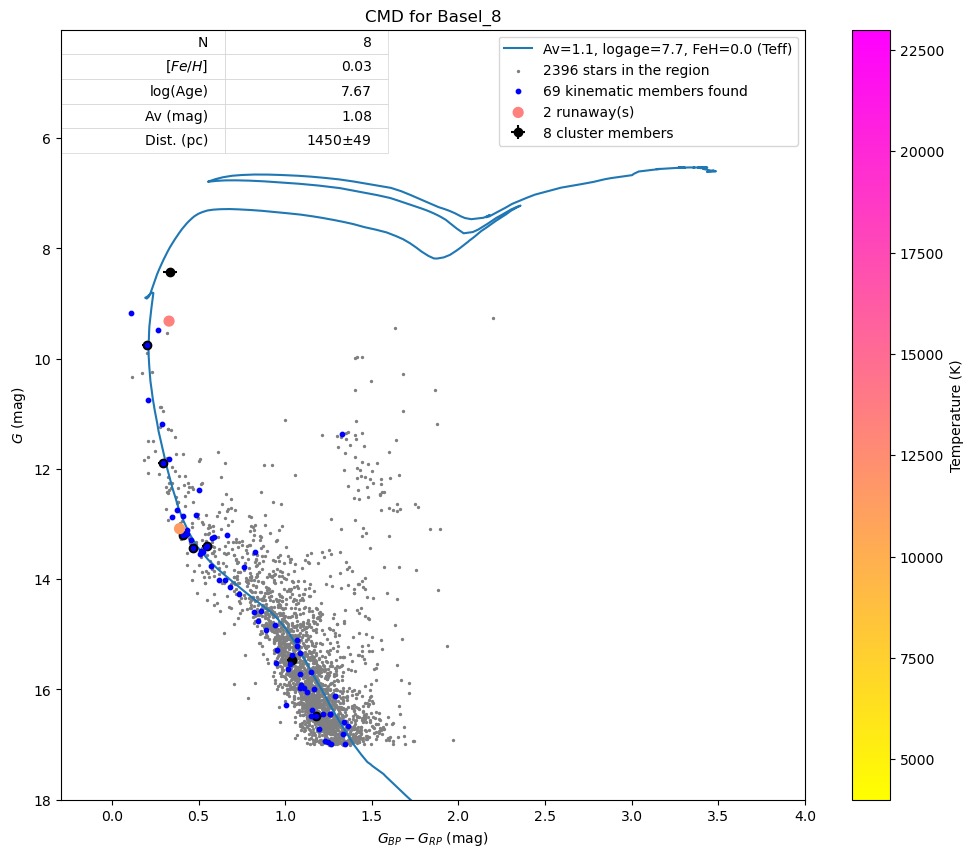

In [22]:
plot_cmd(cl)

getting from /home/surodeep/suro_aiu/traceback/cluster_runaway/
getting from /home/surodeep/suro_aiu/traceback/cluster_runaway/
getting from /home/surodeep/suro_aiu/traceback/cluster_runaway/


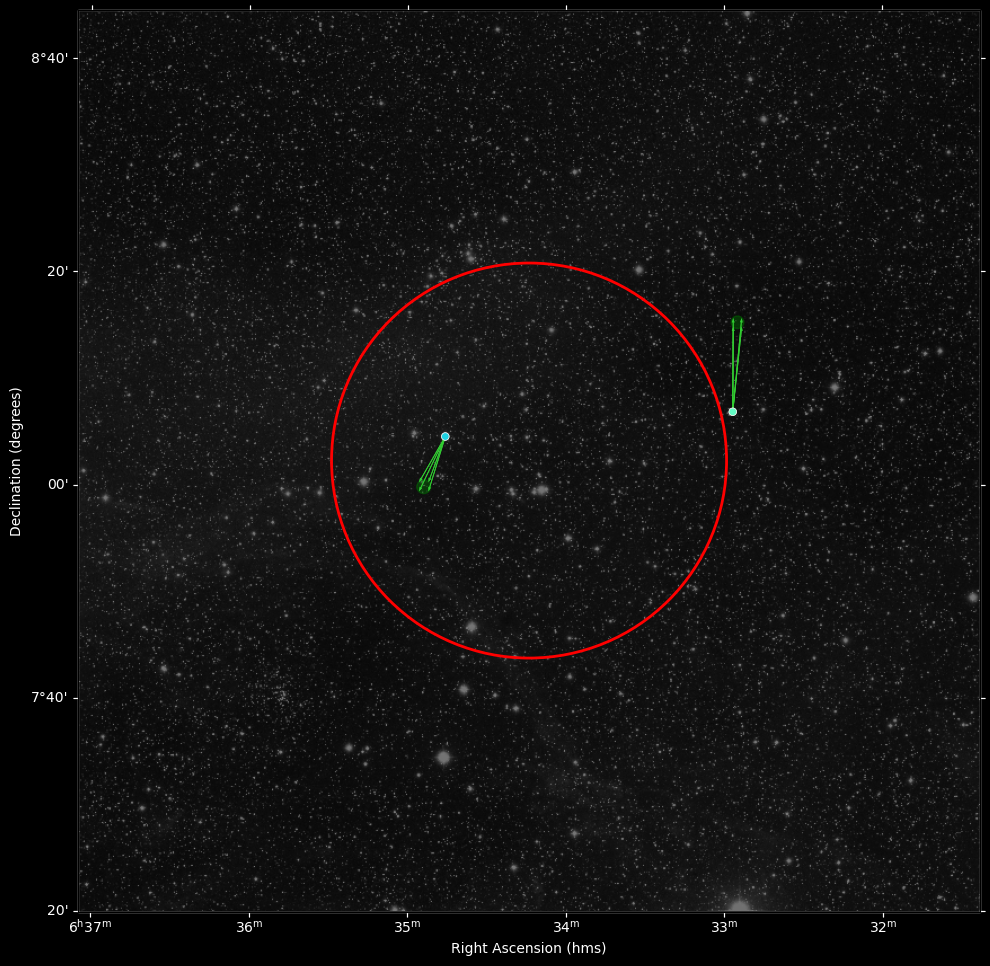

In [23]:
cl.plot_traceback_clean()

In [3]:
from astropy.table import Table
import numpy as np
import astropy.units as u

# Read the data from the .tsv file into an Astropy table
fs4 = Table.read('/home/surodeep/suro_aiu/traceback/cluster_runaway3d/Basel_8/Basel_8_fs4giesler.tsv', format='ascii.tab')

# Line numbers to filter (adjusted by -2 for zero-based indexing)
linenos = [5, 27, 30, 36, 37, 45, 53, 54, 56, 62, 65, 71, 72, 81, 82, 84, 103, 107, 115, 117, 119, 120, 123, 125, 128, 137, 139, 140, 141, 144, 145, 146, 150, 152, 161, 167, 170, 174, 176, 178, 187, 190, 193, 198, 204, 206, 207, 208, 209]

# Create a subset of fs4 based on the specified line numbers
gr = fs4[np.array(linenos) - 2]

# Convert the 'Source' column to integer type
gr['Source'] = gr['Source'].astype(np.int64)

# Convert 'RV' and 'e_RV' columns to float
gr['RV'] = gr['RV'].astype(np.float64)
gr['e_RV'] = gr['e_RV'].astype(np.float64)

# Assuming fs is your first table with a 'Source' column
cl = Cluster("Basel_8")
fs = cl.stars_in_region()

# Extract the 'Source' columns from both tables
fs_sources = fs['Source']
other_sources = gr['Source']

# Convert the 'Source' column of the second table to a set for fast lookup
other_sources_set = set(gr['Source'])

# Filter the first table to include only rows where 'Source' is in the second table's 'Source' column
filtered_fs = fs[[source in set(gr['Source']) for source in fs['Source']]]

# Create a mapping from 'Source' to indices in gr
source_to_index = {source: idx for idx, source in enumerate(gr['Source'])}

# Replace the RV and e_RV values in the filtered_fs table with the values from the gr table
for row in filtered_fs:
    if row['Source'] in source_to_index:
        idx = source_to_index[row['Source']]
        row['RV'] = gr['RV'][idx]  # Assigning with units
        row['e_RV'] = gr['e_RV'][idx]   # Assigning with units

# Now filtered_fs contains only the rows with matching 'Source' values and updated RV and e_RV values
filtered_fs


RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,e_rmRA,e_rmDE,rRV,e_rRV,v_pec,v_pec3d,e_vpec,e_vpec3d
deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s,km / s,km / s,km / s,km / s
float64,float64,float64,float64,float64,int32,str10,int64,float64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,str1,str1,float64,float32,float32,float32,SkyCoord,float64,float64,float32,float32,float64,float32,float64,float64,float64,float64
98.38429327278,8.33557580226,0.0298,0.0279,20.6218,--,733-1218-1,3326048448124872320,1517.70947000,0.6283,0.0363,-0.760,-1.057,0.035,0.028,1.363,32036.6,3.9984,8.432107,0.337074,8.528219,8.191145,67.90,17.90,1442.38904000,1621.94727000,7981856.09929,1.935e+04,5.298e+06,4.473e+04,4.195e+06,3.635e+04,--,--,0.00381,0.009581,0.01014,0.01972,"98.38429327278,8.33557580226,1517.70947",-0.5703750050067902,1.1261250190734864,0.2598477,0.2528477,--,--,9.081153222849567,--,2.3092690045811937,--
98.69055275937,8.07569472560,0.0356,0.0302,8.1797,--,733-1687-1,3326026144355977472,1458.14001000,0.6601,0.0421,-1.403,0.651,0.039,0.031,1.529,--,--,9.317637,0.329390,9.419267,9.089877,27.80,3.40,1378.07080000,1536.19507000,3530953.30802,1620,2.332e+06,5770,1.833e+06,2216,--,--,0.0028,0.003873,0.004001,0.007874,"98.69055275937,8.0756947256,1458.14001",-1.2133750050067902,2.834125019073486,0.26384768,0.2558477,--,--,21.30802513378318,--,5.478361559307416,--
98.55031962528,7.98752507297,0.0259,0.0256,3.0701,--,733-1512-1,3326023842254469120,1409.47327000,0.6747,0.0338,-0.049,-2.251,0.033,0.026,1.305,11353.8,3.4433,9.743308,0.202579,9.800635,9.598057,20.90,4.80,1354.19275000,1463.96838000,2385742.02510,856.2,1.641e+06,1297,1.148e+06,614.7,--,--,0.002783,0.002919,0.003824,0.006743,"98.55031962528,7.98752507297,1409.47327",0.14062499499320985,-0.06787498092651356,0.2578477,0.2508477,-0.05,15.58,1.0432140600484652,1.04,0.26762581622056764,0.79
98.80943694927,8.02405631161,0.0143,0.0132,14.9497,--,733-1827-1,3325977426545923840,1605.87500000,0.6013,0.0165,2.491,-3.233,0.018,0.016,0.950,--,--,11.189508,1.873466,12.116813,10.243346,54.60,0.20,1569.39270000,1654.23608000,629714.19999,137.1,1.944e+05,153.6,6.336e+05,217.9,--,--,0.002765,0.002919,0.003798,0.006717,"98.80943694927,8.02405631161,1605.875",2.68062499499321,-1.0498749809265138,0.24284768,0.24084769,35.35,9.75,21.913645483039886,41.59,5.315870165917745,8.75
98.37799419586,7.93011583452,0.0136,0.0120,12.5153,--,--,3326019139268528512,1615.52136000,0.6062,0.0144,-1.303,0.983,0.016,0.013,1.087,4842.1,2.4478,12.154881,1.414579,12.795862,11.381283,25.94,0.54,1580.99731000,1654.48535000,258818.01110,59.76,1.04e+05,104.3,2.222e+05,122.4,--,--,0.002767,0.002995,0.003826,0.006822,"98.37799419586,7.93011583452,1615.52136",-1.11337500500679,3.1661250190734864,0.24084769,0.23784769,6.69,10.09,25.700195845925165,26.56,6.121264641064779,6.45
98.38465796891,8.01660382126,0.0151,0.0139,10.3912,--,--,3326021986828594176,1537.57800000,0.6435,0.0177,2.526,0.730,0.018,0.015,1.225,5441.7,2.8704,12.177826,1.488301,12.861065,11.372764,-50.32,0.81,1498.43701000,1579.43616000,253405.60224,53.16,9.795e+04,105.6,2.239e+05,158.6,--,--,0.002765,0.003026,0.003857,0.006883,"98.38465796891,8.01660382126,1537.578",2.7156249949932096,2.9131250190734863,0.24284768,0.23984769,-69.57,10.36,29.025495160384953,75.38,7.002319215635999,9.94
98.26600419235,7.95807513544,0.0134,0.0126,18.0132,--,--,3326031573195604480,1647.55933000,0.5970,0.0157,-2.391,-2.930,0.016,0.014,1.198,--,--,12.479560,1.545814,13.202265,11.656451,41.46,0.48,1615.54565000,168

In [79]:
from astropy.table import Table

# Assuming fs is your first table with a 'Source' column
fs = cl.fast_stars_in_region()

# Assuming you have a second table called other_table
other_table = gr  # Replace this with how you get your other table

# Extract the 'Source' columns
fs_sources = fs['Source']
other_sources = gr['Source']

# Convert the 'Source' column of the second table to a set for fast lookup
other_sources_set = set(other_sources)

# Filter the first table to include only rows where 'Source' is in the second table's 'Source' column
filtered_fs = fs[[source in other_sources_set for source in fs_sources]]

# Now filtered_fs contains only the rows with matching 'Source' values
filtered_fs

RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,e_rmRA,e_rmDE,rRV,e_rRV,v_pec,v_pec3d,e_vpec,e_vpec3d
deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s,km / s,km / s,km / s,km / s
float64,float64,float64,float64,float64,int32,str10,int64,float64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,str1,str1,float64,float32,float32,float32,SkyCoord,float64,float64,float32,float32,float64,float32,float64,float64,float64,float64
98.69055275937,8.07569472560,0.0356,0.0302,8.1797,--,733-1687-1,3326026144355977472,1458.14001000,0.6601,0.0421,-1.403,0.651,0.039,0.031,1.529,--,--,9.317637,0.329390,9.419267,9.089877,--,--,1378.07080000,1536.19507000,3530953.30802,1620,2.332e+06,5770,1.833e+06,2216,--,--,0.0028,0.003873,0.004001,0.007874,"98.69055275937,8.0756947256,1458.14001",-1.2133750050067902,2.834125019073486,0.26384768,0.2558477,--,--,21.30802513378318,--,5.478361559307416,--
98.80943694927,8.02405631161,0.0143,0.0132,14.9497,--,733-1827-1,3325977426545923840,1605.87500000,0.6013,0.0165,2.491,-3.233,0.018,0.016,0.950,--,--,11.189508,1.873466,12.116813,10.243346,54.60,0.20,1569.39270000,1654.23608000,629714.19999,137.1,1.944e+05,153.6,6.336e+05,217.9,--,--,0.002765,0.002919,0.003798,0.006717,"98.80943694927,8.02405631161,1605.875",2.68062499499321,-1.0498749809265138,0.24284768,0.24084769,35.35,9.75,21.913645483039886,41.59,5.315870165917745,8.75
98.37799419586,7.93011583452,0.0136,0.0120,12.5153,--,--,3326019139268528512,1615.52136000,0.6062,0.0144,-1.303,0.983,0.016,0.013,1.087,4842.1,2.4478,12.154881,1.414579,12.795862,11.381283,25.94,0.54,1580.99731000,1654.48535000,258818.01110,59.76,1.04e+05,104.3,2.222e+05,122.4,--,--,0.002767,0.002995,0.003826,0.006822,"98.37799419586,7.93011583452,1615.52136",-1.11337500500679,3.1661250190734864,0.24084769,0.23784769,6.69,10.09,25.700195845925165,26.56,6.121264641064779,6.45
98.38465796891,8.01660382126,0.0151,0.0139,10.3912,--,--,3326021986828594176,1537.57800000,0.6435,0.0177,2.526,0.730,0.018,0.015,1.225,5441.7,2.8704,12.177826,1.488301,12.861065,11.372764,-50.32,0.81,1498.43701000,1579.43616000,253405.60224,53.16,9.795e+04,105.6,2.239e+05,158.6,--,--,0.002765,0.003026,0.003857,0.006883,"98.38465796891,8.01660382126,1537.578",2.7156249949932096,2.9131250190734863,0.24284768,0.23984769,-69.57,10.36,29.025495160384953,75.38,7.002319215635999,9.94
98.26600419235,7.95807513544,0.0134,0.0126,18.0132,--,--,3326031573195604480,1647.55933000,0.5970,0.0157,-2.391,-2.930,0.016,0.014,1.198,--,--,12.479560,1.545814,13.202265,11.656451,41.46,0.48,1615.54565000,1689.18579000,191921.11298,36.26,7.153e+04,57.26,1.724e+05,80.63,--,--,0.002763,0.002922,0.003813,0.006736,"98.26600419235,7.95807513544,1647.55933",-2.20137500500679,-0.7468749809265138,0.24084769,0.23884769,22.21,10.03,18.153986897008576,28.69,4.368611862491293,8.25
98.34092881294,7.89690340384,0.0124,0.0108,15.4420,--,--,3326018589512744576,1371.52686000,0.7157,0.0135,-3.779,-4.955,0.015,0.012,1.043,4824.7,2.5134,12.536233,1.423943,13.183615,11.759672,-50.21,0.71,1342.18860000,1396.87488000,182160.23937,36.83,7.277e+04,55.79,1.568e+05,102.9,--,--,0.002764,0.002912,0.003846,0.006758,"98.34092881294,7.89690340384,1371.52686",-3.58937500500679,-2.7718749809265137,0.23984769,0.23684768,-69.46,10.26,29.482690790480653,75.46,7.038443233170406,9.84
98.20835871192,8.25982571530,0.0164,0.0182,24.6730,--,--,3326228218276590336,1288.01257000,0.7535,0.0243,-4.161,0.406,0.020,0.017,1.154,--,--,12.926841,1.403920,13.563621,12.159701,80.03,1.31,1255.64600000,1321.37048000,127118.94101,

In [64]:
cl = Cluster("Basel_8")
cl.fs4giesler()
# cl.fs4giesler()

TypeInput,RA,DE,Plx,e_Plx,RV,e_RV,RVdist,pmRA,e_pmRA,pmDE,e_pmDE,Source
,,,mas,mas,,,,mas / yr,mas / yr,mas / yr,mas / yr,
int64,str12,str12,float64,float32,int64,int64,int64,float64,float32,float64,float32,str21
1,06 34 13.968,08 02 17.160,0.68965517,0.0266,0,0,0,-0.190,0.225,-2.183,0.225,Basel_8
1,06 36 54.542,07 58 41.645,0.62833833,0.0173,0,0,0,-1.266,0.018,-1.155,0.014,3326053327208023936
1,06 34 45.733,08 04 32.501,0.68580520,0.0421,0,0,0,-1.403,0.039,0.651,0.031,3326026144355977472
1,06 33 58.681,07 45 31.764,0.70307023,0.0311,0,0,0,0.397,0.029,-1.004,0.025,3325966637588331904
1,06 35 40.303,08 24 21.884,0.83878530,0.0316,0,0,0,3.212,0.030,0.952,0.024,3326133660275716480
1,06 35 14.265,08 01 26.603,0.62271347,0.0165,0,0,0,2.491,0.018,-3.233,0.016,3325977426545923840
1,06 33 18.739,07 51 34.531,0.82804133,0.0329,0,0,0,-0.988,0.032,-7.367,0.025,3325994876995037824
1,06 32 37.506,08 34 02.009,0.85097321,0.0189,0,0,0,-1.074,0.020,4.618,0.017,3326255495610553728


In [65]:
cl.fast_stars_in_region()

RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,e_rmRA,e_rmDE,rRV,e_rRV,v_pec,v_pec3d,e_vpec,e_vpec3d
deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s,km / s,km / s,km / s,km / s
float64,float64,float64,float64,float64,int32,str10,int64,float64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,str1,str1,float64,float32,float32,float32,SkyCoord,float64,float64,float32,float32,float64,float32,float64,float64,float64,float64
99.22725858706,7.97823468045,0.0141,0.0136,39.9136,--,733-1788-1,3326053327208023936,1591.49927000,0.5930,0.0173,-1.266,-1.155,0.018,0.014,0.913,4614.2,1.3814,9.252639,2.200538,10.404861,8.204324,49.19,0.16,1548.73706000,1637.15125000,3748792.23428,1598,9.408e+05,1735,4.144e+06,3422,--,--,0.002794,0.003434,0.003884,0.007319,"99.22725858706,7.97823468045,1591.49927",-1.0763750050067902,1.0281250190734863,0.24284768,0.23884769,29.94,9.71,11.228786801637765,31.98,2.705549540248419,9.14
98.69055275937,8.07569472560,0.0356,0.0302,8.1797,--,733-1687-1,3326026144355977472,1458.14001000,0.6601,0.0421,-1.403,0.651,0.039,0.031,1.529,--,--,9.317637,0.329390,9.419267,9.089877,--,--,1378.07080000,1536.19507000,3530953.30802,1620,2.332e+06,5770,1.833e+06,2216,--,--,0.0028,0.003873,0.004001,0.007874,"98.69055275937,8.0756947256,1458.14001",-1.2133750050067902,2.834125019073486,0.26384768,0.2558477,--,--,21.30802513378318,--,5.478361559307416,--
98.49450273357,7.75882325570,0.0234,0.0244,17.1786,--,--,3325966637588331904,1422.33301000,0.6829,0.0311,0.397,-1.004,0.029,0.025,1.989,4636.4,1.8177,10.560462,1.862149,11.482549,9.620399,71.39,2.28,1364.09021000,1480.81653000,1123989.10264,310.9,3.487e+05,336.8,1.125e+06,398.9,--,--,0.002772,0.002981,0.003799,0.00678,"98.49450273357,7.7588232557,1422.33301",0.5866249949932099,1.1791250190734863,0.2538477,0.2498477,52.14,11.83,8.878965392361131,52.89,2.225480673031585,11.67
98.91793033140,8.40607900769,0.0277,0.0232,30.7213,--,--,3326133660275716480,1192.20020000,0.8168,0.0316,3.212,0.952,0.030,0.024,1.821,--,--,11.122290,1.406081,11.761770,10.355689,50.24,0.77,1148.89038000,1250.99280000,669932.02689,165.4,2.696e+05,163.5,5.713e+05,246.5,--,--,0.002768,0.002867,0.003808,0.006675,"98.9179303314,8.40607900769,1192.2002",3.40162499499321,3.1351250190734863,0.25484768,0.2488477,30.99,10.32,26.141773209726033,40.54,6.590592675179801,8.96
98.80943694927,8.02405631161,0.0143,0.0132,14.9497,--,733-1827-1,3325977426545923840,1605.87500000,0.6013,0.0165,2.491,-3.233,0.018,0.016,0.950,--,--,11.189508,1.873466,12.116813,10.243346,54.60,0.20,1569.39270000,1654.23608000,629714.19999,137.1,1.944e+05,153.6,6.336e+05,217.9,--,--,0.002765,0.002919,0.003798,0.006717,"98.80943694927,8.02405631161,1605.875",2.68062499499321,-1.0498749809265138,0.24284768,0.24084769,35.35,9.75,21.913645483039886,41.59,5.315870165917745,8.75
98.32807784189,7.85959204576,0.0283,0.0251,17.3699,--,733-2008-1,3325994876995037824,1207.66919000,0.8004,0.0329,-0.988,-7.367,0.032,0.025,1.391,5133.8,2.7982,11.342217,1.351886,11.946281,10.594396,-26.32,1.19,1168.05396000,1258.94336000,547091.22454,125.6,2.275e+05,103.9,4.586e+05,203.2,--,--,0.002767,0.002834,0.00381,0.006644,"98.32807784189,7.85959204576,1207.66919",-0.7983750050067902,-5.183874980926514,0.25684768,0.2498477,-45.57,10.74,30.02419190903883,54.57,7.506411329747386,9.88
98.15627576457,8.56722476217,0.0173,0.0162,39.7161,--,--,3326255495610553728,1175.12512000,0.8252,0.0189,-1.074,4.618,0.020,0.017,1.133,4952.4,2.7904,11.348566,1.440937,12.007280,10.566343,40.51,0.21,1149.72412000,1201.94348000,5

In [29]:
table = cl.fast_stars_in_region()
mask_vpec3dexists = ~table['v_pec3d'].mask
table = table[mask_vpec3dexists]
table

RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,e_rmRA,e_rmDE,rRV,e_rRV,v_pec,v_pec3d,e_vpec,e_vpec3d
deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s,km / s,km / s,km / s,km / s
float64,float64,float64,float64,float64,int32,str10,int64,float64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,str1,str1,float64,float32,float32,float32,SkyCoord,float64,float64,float32,float32,float64,float32,float64,float64,float64,float64
98.02515215957,8.09905249055,0.0143,0.0142,31.8772,--,733-1181-1,3326201829997700864,1524.07874000,0.6292,0.0183,2.051,-3.571,0.017,0.014,1.133,4553.0,2.0382,10.953504,1.681146,11.758776,10.077630,35.17,0.19,1480.84570000,1572.99548000,782610.13964,172.5,2.703e+05,215.5,7.381e+05,266.9,--,--,0.002766,0.002921,0.0038,0.006721,"98.02515215957,8.09905249055,1524.07874",2.24062499499321,-1.3878749809265138,0.2418477,0.23884769,15.92,9.74,19.040213295718296,24.82,4.589064109963333,7.17
98.91793033140,8.40607900769,0.0277,0.0232,30.7213,--,--,3326133660275716480,1192.20020000,0.8168,0.0316,3.212,0.952,0.030,0.024,1.821,--,--,11.122290,1.406081,11.761770,10.355689,50.24,0.77,1148.89038000,1250.99280000,669932.02689,165.4,2.696e+05,163.5,5.713e+05,246.5,--,--,0.002768,0.002867,0.003808,0.006675,"98.9179303314,8.40607900769,1192.2002",3.40162499499321,3.1351250190734863,0.25484768,0.2488477,30.99,10.32,26.141773209726033,40.54,6.590592675179801,8.96
98.80943694927,8.02405631161,0.0143,0.0132,14.9497,--,733-1827-1,3325977426545923840,1605.87500000,0.6013,0.0165,2.491,-3.233,0.018,0.016,0.950,--,--,11.189508,1.873466,12.116813,10.243346,54.60,0.20,1569.39270000,1654.23608000,629714.19999,137.1,1.944e+05,153.6,6.336e+05,217.9,--,--,0.002765,0.002919,0.003798,0.006717,"98.80943694927,8.02405631161,1605.875",2.68062499499321,-1.0498749809265138,0.24284768,0.24084769,35.35,9.75,21.913645483039886,41.59,5.315870165917745,8.75
98.32807784189,7.85959204576,0.0283,0.0251,17.3699,--,733-2008-1,3325994876995037824,1207.66919000,0.8004,0.0329,-0.988,-7.367,0.032,0.025,1.391,5133.8,2.7982,11.342217,1.351886,11.946281,10.594396,-26.32,1.19,1168.05396000,1258.94336000,547091.22454,125.6,2.275e+05,103.9,4.586e+05,203.2,--,--,0.002767,0.002834,0.00381,0.006644,"98.32807784189,7.85959204576,1207.66919",-0.7983750050067902,-5.183874980926514,0.25684768,0.2498477,-45.57,10.74,30.02419190903883,54.57,7.506411329747386,9.88
98.15627576457,8.56722476217,0.0173,0.0162,39.7161,--,--,3326255495610553728,1175.12512000,0.8252,0.0189,-1.074,4.618,0.020,0.017,1.133,4952.4,2.7904,11.348566,1.440937,12.007280,10.566343,40.51,0.21,1149.72412000,1201.94348000,543901.81906,159.3,2.15e+05,135.1,4.706e+05,233.1,--,--,0.002774,0.002872,0.003817,0.00669,"98.15627576457,8.56722476217,1175.12512",-0.8843750050067902,6.801125019073487,0.24484769,0.2418477,21.26,9.76,38.201832951479794,43.72,9.240942431076014,9.37
98.22562558636,7.71688625045,0.0154,0.0148,27.6070,--,--,3325989001488975104,1600.60449000,0.5939,0.0186,-2.467,-1.681,0.020,0.015,0.785,--,--,11.375305,1.212525,11.901155,10.688629,13.60,1.29,1553.27344000,1645.29480000,530670.07959,124.9,2.371e+05,116.6,4.204e+05,128.6,--,--,0.002767,0.002841,0.003794,0.006635,"98.22562558636,7.71688625045,1600.60449",-2.2773750050067902,0.5021250190734863,0.24484769,0.23984769,-5.65,10.84,17.693126886092205,18.57,4.328059908004289,5.28
97.96487496352,8.37047650789,0.0135,0.0125,40.4878,--,--,3326245913541910144,1298.25244000,0.7440,0.0154,-5.272,1.867,0.016,0.014,0.975,4912.7,2.5467,11.382548,1.399843,12.016293,10.616449,53.85,0.25,1269.80774

In [31]:
cl.prepare_trace3d()

./traceback ../../cluster_runaway3d/Basel_8/Basel_8_trace.conf


In [30]:
cl.fs4giesler3d()

TypeInput,RA,DE,Plx,e_Plx,RV,e_RV,RVdist,pmRA,e_pmRA,pmDE,e_pmDE,Source
,,,mas,mas,km / s,km / s,,mas / yr,mas / yr,mas / yr,mas / yr,
int64,str12,str12,float64,float32,float64,float32,int64,float64,float32,float64,float32,str21
1,06 34 13.968,08 02 17.160,0.68965517,0.0266,19.25,9.55,0,-0.190,0.225,-2.183,0.225,Basel_8
1,06 32 06.037,08 05 56.589,0.65613408,0.0183,35.17,0.19,0,2.051,0.017,-3.571,0.014,3326201829997700864
1,06 35 40.303,08 24 21.884,0.83878530,0.0316,50.24,0.77,0,3.212,0.030,0.952,0.024,3326133660275716480
1,06 35 14.265,08 01 26.603,0.62271347,0.0165,54.60,0.20,0,2.491,0.018,-3.233,0.016,3325977426545923840
1,06 33 18.739,07 51 34.531,0.82804133,0.0329,-26.32,1.19,0,-0.988,0.032,-7.367,0.025,3325994876995037824
1,06 32 37.506,08 34 02.009,0.85097321,0.0189,40.51,0.21,0,-1.074,0.020,4.618,0.017,3326255495610553728
1,06 32 54.150,07 43 00.791,0.62476396,0.0186,13.60,1.29,0,-2.467,0.020,-1.681,0.015,3325989001488975104
1,06 31 51.570,08 22 13.715,0.77026622,0.0154,53.85,0.25,0,-5.272,0.016,1.867,0.014,3326245913541910144


getting isochrone from cmd3.7 (PARSEC2) with:
Av:1.08
logage:7.67
metallicity:0.03
isochrone downloaded in 7.8s
getting from /home/surodeep/suro_aiu/traceback/cluster_runaway3d/


<Figure size 640x480 with 0 Axes>

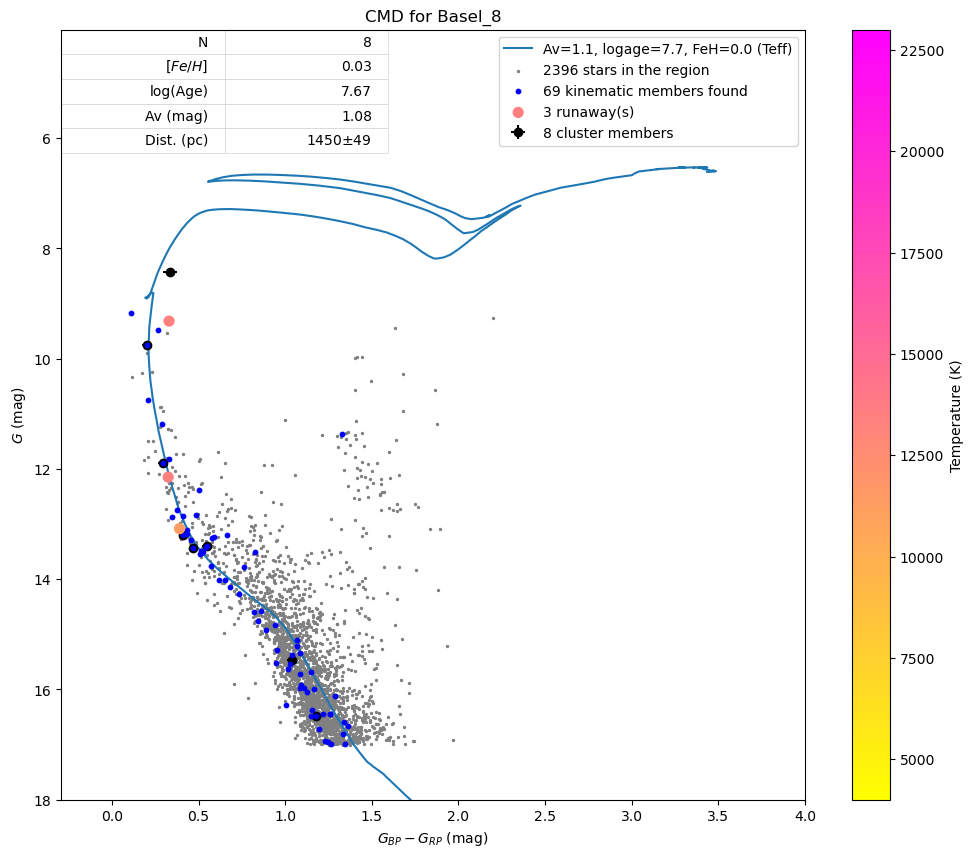

In [5]:
plot_cmd(cl)

getting from /home/surodeep/suro_aiu/traceback/cluster_runaway3d/
getting from /home/surodeep/suro_aiu/traceback/cluster_runaway3d/
getting from /home/surodeep/suro_aiu/traceback/cluster_runaway3d/


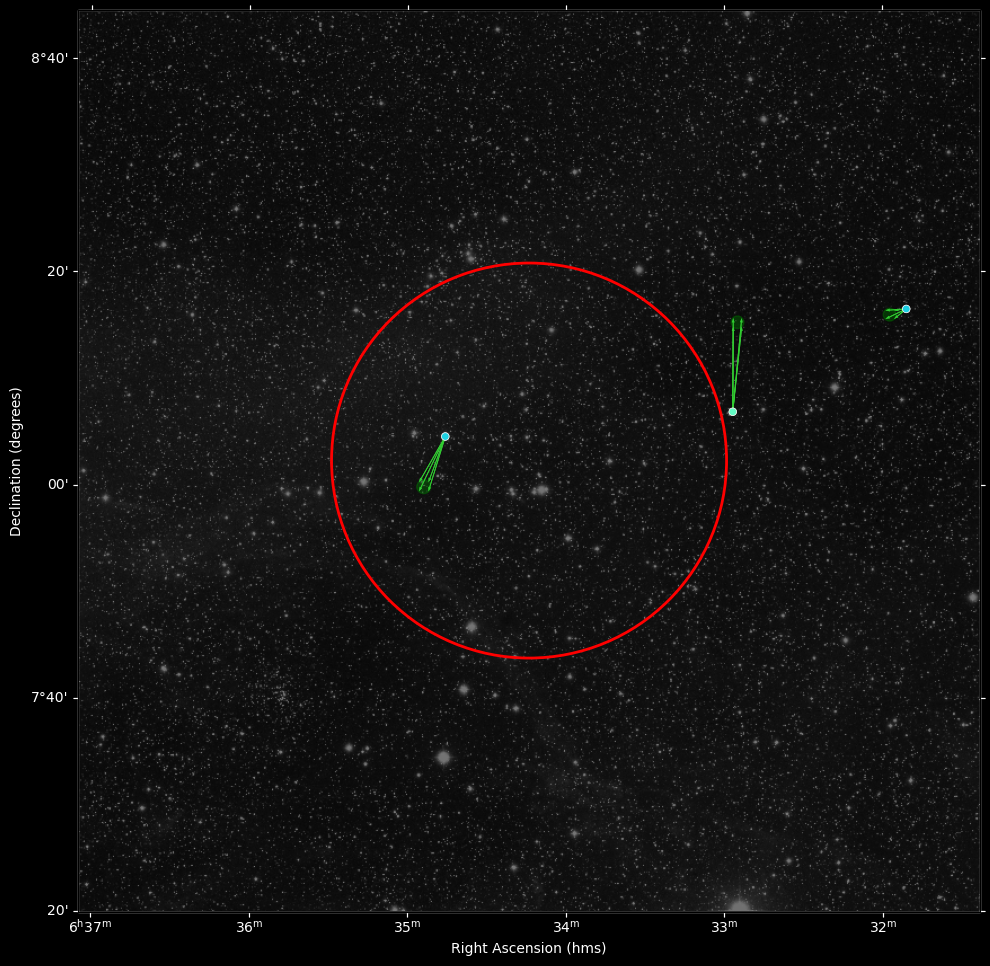

In [6]:
cl.plot_traceback_clean()

In [41]:
cl = Cluster("Basel_8")

cl.fs4giesler3d(outlocation="remote")
# len(cl.stars_in_region(3326023842254469120).colnames)

TypeInput,RA,DE,Plx,e_Plx,RV,e_RV,RVdist,pmRA,e_pmRA,pmDE,e_pmDE,Source
,,,mas,mas,km / s,km / s,,mas / yr,mas / yr,mas / yr,mas / yr,
int64,str12,str12,float64,float32,float64,float32,int64,float64,float32,float64,float32,str21
1,06 34 13.968,08 02 17.160,0.68965517,0.0266,19.25,9.55,0,-0.190,0.225,-2.183,0.225,Basel_8
1,06 36 54.542,07 58 41.645,0.62833833,0.0173,49.19,0.16,0,-1.266,0.018,-1.155,0.014,3326053327208023936
1,06 33 58.681,07 45 31.764,0.70307023,0.0311,71.39,2.28,0,0.397,0.029,-1.004,0.025,3325966637588331904
1,06 35 40.303,08 24 21.884,0.83878530,0.0316,50.24,0.77,0,3.212,0.030,0.952,0.024,3326133660275716480
1,06 35 14.265,08 01 26.603,0.62271347,0.0165,54.60,0.20,0,2.491,0.018,-3.233,0.016,3325977426545923840
1,06 33 18.739,07 51 34.531,0.82804133,0.0329,-26.32,1.19,0,-0.988,0.032,-7.367,0.025,3325994876995037824
1,06 32 37.506,08 34 02.009,0.85097321,0.0189,40.51,0.21,0,-1.074,0.020,4.618,0.017,3326255495610553728
1,06 31 51.570,08 22 13.715,0.77026622,0.0154,53.85,0.25,0,-5.272,0.016,1.867,0.014,3326245913541910144


In [37]:
len(f.colnames)

49

In [35]:
cl = Cluster("Basel_8")
f = cl.fast_stars_in_region()
mask_vpec3dexists = ~f['v_pec3d'].mask
f[f['Source']==3326023842254469120]

RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,e_rmRA,e_rmDE,rRV,e_rRV,v_pec,v_pec3d,e_vpec,e_vpec3d
deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s,km / s,km / s,km / s,km / s
float64,float64,float64,float64,float64,int32,str10,int64,float64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,str1,str1,float64,float32,float32,float32,SkyCoord,float64,float64,float32,float32,float64,float32,float64,float64,float64,float64


In [4]:
workclusters3d = []
for cluster in workclusters[:]:
    cl = Cluster(cluster)
    if not isinstance(cl.RV, np.ma.core.MaskedConstant):
        workclusters3d.append(cluster)


In [16]:
workclusters3d, len(workclusters3d)

(['ASCC_107',
  'ASCC_114',
  'ASCC_127',
  'ASCC_13',
  'ASCC_16',
  'ASCC_19',
  'ASCC_21',
  'ASCC_32',
  'Alessi_20',
  'Alessi_43',
  'Alessi_Teutsch_5',
  'Archinal_1',
  'Aveni_Hunter_1',
  'BDSB91',
  'BDSB93',
  'BDSB96',
  'BH_121',
  'BH_200',
  'BH_205',
  'BH_221',
  'BH_54',
  'BH_56',
  'BH_87',
  'Basel_8',
  'Berkeley_86',
  'Berkeley_87',
  'Bica_2',
  'Biurakan_2',
  'Bochum_10',
  'Bochum_11',
  'Bochum_13',
  'COIN-Gaia_21',
  'COIN-Gaia_41',
  'Collinder_104',
  'Collinder_106',
  'Collinder_107',
  'Collinder_132',
  'Collinder_197',
  'Collinder_272',
  'Collinder_419',
  'Collinder_421',
  'Collinder_69',
  'Collinder_95',
  'Czernik_41',
  'Dias_5',
  'Dolidze_16',
  'Dolidze_32',
  'Dolidze_5',
  'Dolidze_53',
  'Dolidze_8',
  'ESO_332_08',
  'ESO_332_13',
  'FSR_0165',
  'FSR_0236',
  'FSR_0306',
  'FSR_0336',
  'FSR_0398',
  'FSR_0551',
  'FSR_0686',
  'FSR_0904',
  'Gulliver_10',
  'Gulliver_19',
  'Gulliver_2',
  'Gulliver_26',
  'Gulliver_31',
  'Gullive

In [30]:
print(workclusters)

['ASCC_107', 'ASCC_114', 'ASCC_127', 'ASCC_13', 'ASCC_16', 'ASCC_19', 'ASCC_21', 'ASCC_32', 'ASCC_67', 'ASCC_9', 'Alessi_20', 'Alessi_43', 'Alessi_Teutsch_5', 'Antalova_2', 'Archinal_1', 'Aveni_Hunter_1', 'BDSB91', 'BDSB93', 'BDSB96', 'BH_121', 'BH_200', 'BH_205', 'BH_217', 'BH_221', 'BH_245', 'BH_54', 'BH_56', 'BH_87', 'BH_92', 'Barkhatova_1', 'Basel_18', 'Basel_8', 'Berkeley_11', 'Berkeley_15', 'Berkeley_47', 'Berkeley_62', 'Berkeley_65', 'Berkeley_7', 'Berkeley_79', 'Berkeley_86', 'Berkeley_87', 'Berkeley_97', 'Bica_2', 'Biurakan_2', 'Bochum_10', 'Bochum_11', 'Bochum_13', 'COIN-Gaia_16', 'COIN-Gaia_21', 'COIN-Gaia_35', 'COIN-Gaia_41', 'Collinder_104', 'Collinder_106', 'Collinder_107', 'Collinder_132', 'Collinder_197', 'Collinder_205', 'Collinder_272', 'Collinder_419', 'Collinder_421', 'Collinder_69', 'Collinder_95', 'Czernik_1', 'Czernik_31', 'Czernik_41', 'Czernik_6', 'Czernik_8', 'Dias_1', 'Dias_5', 'Dolidze_16', 'Dolidze_3', 'Dolidze_32', 'Dolidze_5', 'Dolidze_53', 'Dolidze_8', '

In [57]:
%run runaway_functionsv3
cl = Cluster("")

cl.members()

[3326048448124872320, 3326023842254469120] found from config file
116 out of 260 dias members found in search region
Changed N          31.00 --> 8.00
Changed Plx        0.62 --> 0.65
Changed e_Plx      0.04 --> 0.03
Changed Dist       1456.00 --> 1450.12
Changed e_Dist     54.00 --> 49.96
Changed pmRA       -0.13 --> -0.19
Changed e_pmRA     0.07 --> 0.22
Changed pmDE       -2.40 --> -2.18
Changed e_pmDE     0.14 --> 0.22
Changed RV         -- --> 19.25
Changed e_RV       -- --> 9.55
Changed NRV        -- --> 8.00


RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,e_rmRA,e_rmDE,rRV,e_rRV,v_pec,v_pec3d,e_vpec,e_vpec3d,Pmemb
deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s,km / s,km / s,km / s,km / s,
float64,float64,float64,float64,float64,int32,str10,int64,float64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,str1,str1,float64,float32,float32,float32,SkyCoord,float64,float64,float32,float32,float64,float32,float64,float64,float64,float64,float64
98.38429327278,8.33557580226,0.0298,0.0279,20.6218,--,733-1218-1,3326048448124872320,1517.70947000,0.6283,0.0363,-0.760,-1.057,0.035,0.028,1.363,32036.6,3.9984,8.432107,0.337074,8.528219,8.191145,--,--,1442.38904000,1621.94727000,7981856.09929,1.935e+04,5.298e+06,4.473e+04,4.195e+06,3.635e+04,--,--,0.00381,0.009581,0.01014,0.01972,"98.38429327278,8.33557580226,1517.70947",-0.5703750050067902,1.1261250190734864,0.2598477,0.2528477,--,--,9.081153222849567,--,2.3092690045811937,--,1.0
98.55031962528,7.98752507297,0.0259,0.0256,3.0701,--,733-1512-1,3326023842254469120,1409.47327000,0.6747,0.0338,-0.049,-2.251,0.033,0.026,1.305,11353.8,3.4433,9.743308,0.202579,9.800635,9.598057,19.20,6.03,1354.19275000,1463.96838000,2385742.02510,856.2,1.641e+06,1297,1.148e+06,614.7,--,--,0.002783,0.002919,0.003824,0.006743,"98.55031962528,7.98752507297,1409.47327",0.14062499499320985,-0.06787498092651356,0.2578477,0.2508477,-0.05,7.14,1.0432140600484652,1.04,0.26762581622056764,0.43,1.0
98.54082660573,8.01212878661,0.0194,0.0180,1.8691,--,733-2228-1,3326024117132373632,1445.86487000,0.6384,0.0232,-0.182,-2.405,0.024,0.021,1.032,--,--,11.888272,0.294881,11.986523,11.691642,--,--,1405.83179000,1494.29736000,330855.23367,85.93,2.192e+05,175.4,1.669e+05,94.7,--,--,0.00277,0.002922,0.003829,0.006752,"98.54082660573,8.01212878661,1445.86487",0.007624994993209844,-0.22187498092651348,0.2488477,0.24584769,--,--,1.5214955538026567,--,0.3740615801533191,--,0.8
98.47991490921,8.04956098629,0.0149,0.0133,4.7019,--,--,3326028175879616256,1452.00476000,0.6440,0.0172,-0.121,-2.316,0.019,0.016,1.081,9561.1,4.0650,13.194690,0.412356,13.343504,12.931148,--,--,1423.29114000,1486.77441000,99327.79055,60.73,6.281e+04,46.62,5.33e+04,36.04,--,--,0.002834,0.002904,0.00385,0.006754,"98.47991490921,8.04956098629,1452.00476",0.06862499499320984,-0.1328749809265135,0.24384768,0.24084769,--,--,1.029277061512286,--,0.2485523901457674,--,0.8
98.55007006085,7.86501938128,0.0137,0.0141,10.3957,--,--,3325969180208898432,1470.48962000,0.6390,0.0173,-0.089,-2.365,0.017,0.014,1.110,9412.0,4.0243,13.391542,0.548879,13.596915,13.048037,--,--,1434.64990000,1507.35620000,82857.08176,32.24,4.973e+04,34.79,4.786e+04,27.08,--,--,0.002788,0.002892,0.003829,0.006721,"98.55007006085,7.86501938128,1470.48962",0.10062499499320984,-0.18187498092651389,0.2418477,0.23884769,--,--,1.448777766372426,--,0.3470607243596529,--,0.9
98.47750157250,8.18827800746,0.0134,0.0127,10.2068,--,--,3326041335659347072,1507.59143000,0.6195,0.0153,-0.189,-2.312,0.017,0.014,0.870,9455.0,4.0699,13.434296,0.469467,13.606323,13.136856,--,--,1478.83008000,1540.77148000,79657.81580,32.15,4.93e+04,47.39,4.41e+04,27.86,--,--,0.00279,0.002979,0.003841,0.00682,"98.4775015725,8.18827800746,1507.59143",0.0006249949932098375,-0.1288749809265135,0.2418477,0.23884769,--,--,0.9209493012040895,--,0.21996667659651986,--,0.8
98.24454758674,8.31487809120,0.0295,0.0282,24.9560,--,--,3326235124583953024,1350.09131000,0.7037,0.0356,-0.143,-2.324,0.035,0.029,1.018,6085.7,4.3650,15.458742,1.038140,15.888773,14.850633,--,--,1285.37537000

In [55]:
cl = Cluster("Berkeley_97")
cl.runaways()

getting from /home/surodeep/suro_aiu/traceback/cluster_runaway/


RA_ICRS_1,DE_ICRS_1,rgeo,Teff,Temp. Est,v_pec,v_pec3d,HIP,TYC2,Source,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Gmag,BP-RP,BPmag,RPmag,b_rgeo,B_rgeo,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,e_rmRA,rmDE,e_rmDE,logg,RV,e_RV,rRV,e_rRV,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6
deg,deg,pc,K,K,km / s,km / s,,,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,mag,mag,pc,pc,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,log(cm.s**-2),km / s,km / s,km / s,km / s,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,int32,str11,int64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,SkyCoord,float64,float32,float64,float32,float64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,str1,str1
339.89581711423,58.99547917199,2620.36230000,9168.0,10920.0,29.98008203419036,--,--,--,2008384504995669248,0.3560,0.0241,-0.379,-1.352,0.025,0.024,1.086,15.384143,1.182070,15.883185,14.701116,2461.53345000,2759.61401000,0.00277,0.003852,0.004229,0.008081,"339.89581711423,58.99547917199,2620.3623",2.3543571910858154,0.12397915,0.5321785192489623,0.12297915,3.7061,--,--,--,--,13221.76503,3.482,6055,14.81,1.044e+04,18.25,--,--


getting from /home/surodeep/suro_aiu/traceback/cluster_runaway/


<Figure size 640x480 with 0 Axes>

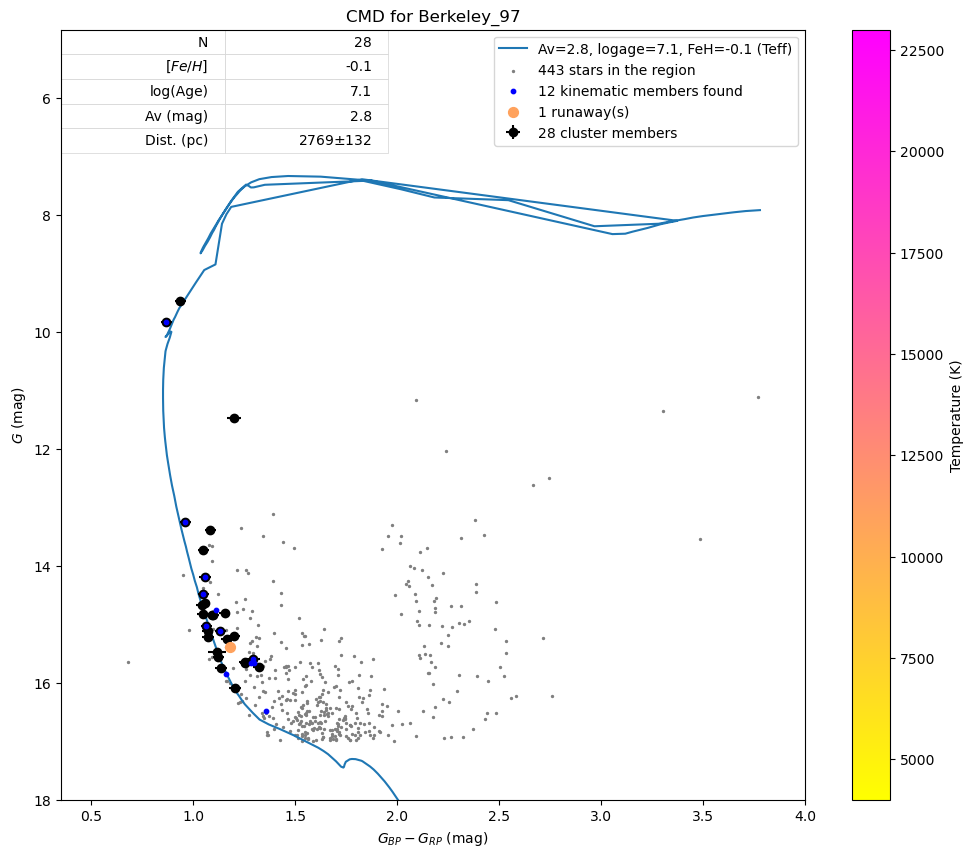

In [56]:
plot_cmd(cl)

In [ ]:
cluster = Cluster("Basel_8")
def fast_stars_in_region(cluster):
    sir = cluster.stars_in_region()
    mask_fast = sir['v_pec'] > 17.6*u.km/u.s
    return sir[mask_fast]
fast_stars_in_region(cluster)

In [ ]:
for cluster in workclusters[:]:
    print("-"*50)
    print(cluster)
    print("-"*50)
    Cluster(cluster).members()

In [26]:
dias2021 = Table.read('dias2021.tsv', format='ascii.ecsv')
dias2021[dias2021['Cluster']=='Basel_8']

Cluster,RA_ICRS,DE_ICRS,r50,N,pmRA,e_pmRA,pmDE,e_pmDE,Plx,e_Plx,RV,e_RV,NRV,Dist,e_Dist,logage,e_logage,__Fe_H_,e__Fe_H_,Av,e_Av,FileName,SimbadName,_RA.icrs,_DE.icrs
,deg,deg,deg,,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,,pc,pc,log(yr),log(yr),,,mag,mag,,,deg,deg
str17,float64,float64,float32,int16,float32,float32,float32,float32,float32,float32,float64,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,str31,str31,float64,float64
Basel_8,98.5582,8.0381,0.299,31,-0.134,0.066,-2.400,0.140,0.623,0.036,--,--,--,1456,54,7.671,0.236,0.028,0.064,1.083,0.079,clusters1/Basel_8.dat,Cl Basel 8,98.5582,8.0381


In [ ]:
Simbad.query_object(star)

In [26]:
Vizier(catalog="I/355/gaiadr3").query_object("Gaia DR3 2008384504995669248")

TableList with 1 tables:
	'0:I/355/gaiadr3' with 57 column(s) and 50 row(s) 

In [42]:
obs = config['observed_stars']['Basel_8']

for star in obs:
    print(get_main_name(star), star)
    
    


HD 259597 3326048448124872320
HD 259787 3326023842254469120
HD 259991 3326026144355977472


In [46]:
%run runaway_functionsv3

cl = Cluster("ASCC_21")

cl.runaways_all().show_in_notebook()

getting from /home/surodeep/suro_aiu/traceback/cluster_runaway/


idx,RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,e_rmRA,e_rmDE,rRV,e_rRV,v_pec,v_pec3d,e_vpec,e_vpec3d
,deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s,km / s,km / s,km / s,km / s
0,82.10374361866,3.61618717097,0.0461,0.0349,8.6592,--,--,3236063037820601984,358.56320200,2.7682,0.0535,-2.898,17.429,0.060,0.040,2.568,5932.7,4.0803,11.264802,0.721487,11.546015,10.824528,-9.74,1.58,351.43402100,366.37118500,587524.28598,240.5,3.289e+05,163.1,3.71e+05,125,--,--,0.002791,0.002842,0.003797,0.006639,"82.10374361866,3.61618717097,358.563202",-4.289456484794616,18.10839132452011,0.2653944,0.24539438,-25.27,7.34,31.628502335042878,40.48,7.796355903073296,7.62
1,82.37215578713,3.18370709039,0.0113,0.0086,22.3478,--,--,3235981158562939904,331.50784300,2.9825,0.0137,-6.208,-24.029,0.013,0.010,0.925,5674.7,4.3140,11.989429,0.801538,12.307569,11.506032,-26.94,0.54,330.06628400,333.14740000,301422.10996,51.35,1.631e+05,77.14,1.98e+05,63.16,--,--,0.002762,0.002837,0.003795,0.006632,"82.37215578713,3.18370709039,331.507843",-7.599456484794617,-23.34960867547989,0.21839438,0.2153944,-42.47,6.30,38.58468392667965,57.38,8.322081288146565,7.29
2,82.45366276132,3.95809953891,0.0469,0.0390,34.3575,--,109-643-1,3236098909387483392,342.99548300,2.8911,0.0567,5.730,26.158,0.066,0.048,4.045,--,--,12.015404,0.797601,12.328853,11.531252,58.39,0.87,336.44738800,349.10391200,294296.47426,82.43,1.599e+05,77.52,1.935e+05,67.69,--,--,0.002772,0.002839,0.003798,0.006638,"82.45366276132,3.95809953891,342.995483",4.338543515205384,26.837391324520112,0.27139437,0.2533944,42.86,6.63,44.19865955138978,61.57,11.220654738177204,9.28
3,81.73123676159,3.39471048675,0.0114,0.0092,25.1112,--,--,3235959241346141824,343.22427400,2.8879,0.0126,-7.521,-29.480,0.015,0.011,0.976,5918.6,4.3214,12.238371,0.786714,12.550327,11.763614,-9.61,0.84,341.96810900,344.77526900,239661.58109,50.97,1.304e+05,50.86,1.562e+05,53.46,--,--,0.002765,0.002822,0.003798,0.00662,"81.73123676159,3.39471048675,343.224274",-8.912456484794617,-28.80060867547989,0.22039439,0.2163944,-25.14,6.60,49.04740635280576,55.12,10.630873711008773,9.93
4,82.35369194168,2.64361355689,0.0125,0.0103,51.5877,--,--,3223851758602238464,337.35769700,2.9358,0.0168,1.884,-36.201,0.017,0.013,1.001,5638.1,4.4469,12.670722,0.859139,13.017700,12.158562,102.05,1.41,335.25412000,339.10046400,160937.75071,33.02,8.479e+04,46.2,1.086e+05,43.49,--,--,0.002764,0.002852,0.003804,0.006657,"82.35369194168,2.64361355689,337.357697",0.4925435152053832,-35.52160867547989,0.22239439,0.21839438,86.52,7.17,56.80719385446505,103.50,12.406416176718,9.07
5,82.28645574203,2.95263532084,0.0123,0.0098,32.6309,--,--,3223873336517853312,340.77206400,2.8897,0.0151,24.801,-14.116,0.016,0.012,1.002,5219.3,4.5549,13.534492,1.026991,13.966669,12.939678,47.62,2.57,339.16766400,342.53802500,72635.66953,12.13,3.538e+04,23.32,5.288e+04,24.13,--,--,0.002761,0.00288,0.003812,0.006692,"82.28645574203,2.95263532084,340.772064",23.40954351520538,-13.436608675479889,0.22139439,0.21739438,32.09,8.33,43.598521649342466,54.13,9.60954622656386,9.18
6,83.30630491305,3.10712416731,0.0139,0.0112,73.1729,--,--,3223937249927689728,330.85607900,2.9749,0.0173,74.635,-10.736,0.019,0.014,1.029,4759.2,4.5431,13.922915,1.183894,14.437791,13.253897,40.98,2.90,329.05035400,333.03347800,50790.25977,6.719,2.292e+04,17.17,3.959e+04,25.76,--,--,0.002759,0.002906,0.003845,0.006751,"83.30630491305,3.10712416731,330.856079",73.24354351520539,-10.05660867547989,0.22439438,0.21939439,25.45,8.66,115.94243663391592,118.70,26.006221972482315,25.47
7,82.06763912165,2.98652211859,0.1503,0.1209,29.7723,--,--,3235885501051423360,319.98010300,3.1423,0.1924

In [52]:
"IC_2395" in workclusters3d

True

In [47]:
len(workclusters3d)

265

In [45]:
sir = cl.stars_in_region()
mask_fast2d = sir['v_pec'] > 17.6*u.km/u.s
mask_vpec3ddosentexist = sir['v_pec3d'].mask
mask_fast3d = sir['v_pec3d'] > 25*u.km/u.s
sir[(mask_fast2d & mask_vpec3ddosentexist) | mask_fast3d]

RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,e_rmRA,e_rmDE,rRV,e_rRV,v_pec,v_pec3d,e_vpec,e_vpec3d
deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s,km / s,km / s,km / s,km / s
float64,float64,float64,float64,float64,int32,str10,int64,float64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,str1,str1,float64,float32,float32,float32,SkyCoord,float64,float64,float32,float32,float64,float32,float64,float64,float64,float64
80.52314432669,3.57162792181,0.0191,0.0135,97.1317,25072,104-1829-1,3236202748812580736,356.07589700,2.7804,0.0218,10.218,-0.828,0.024,0.017,1.027,--,--,6.614078,2.061132,7.659725,5.598593,51.73,0.12,353.23892200,358.56723000,42590766.58342,1.221e+04,1.179e+07,1.235e+04,4.568e+07,2.848e+04,--,--,0.002773,0.003013,0.00384,0.006853,"80.52314432669,3.57162792181,356.075897",8.826543515205383,-0.14860867547988887,0.22939439,0.22239439,36.20,5.88,14.899549292257234,39.15,3.4178439329407517,5.59
81.68710142752,4.08223058422,0.3230,0.2504,45.3982,--,109-2637-1,3236312493817293312,351.18399000,3.1183,0.3820,6.121,-15.713,0.396,0.294,14.212,5533.3,1.9546,6.885698,0.992977,7.219610,6.226633,36.67,0.18,305.99548300,409.00351000,33164038.81402,7.966e+04,1.768e+07,4742,2.562e+07,1.819e+04,--,--,0.003794,0.002805,0.003857,0.006663,"81.68710142752,4.08223058422,351.18399",4.729543515205384,-15.033608675479888,0.6013944,0.4993944,21.14,5.94,26.234306522927167,33.69,13.364224945808331,11.05
80.63167844955,2.98328037037,0.0236,0.0172,95.2204,25106,105-1079-1,3234618932376959488,284.25741600,3.4862,0.0289,5.108,-7.017,0.029,0.021,1.215,--,--,7.760268,0.270155,7.845491,7.575336,41.14,0.46,281.78576700,286.17569000,14819704.19796,3562,9.936e+06,4634,7.396e+06,3553,--,--,0.002768,0.002836,0.003815,0.006651,"80.63167844955,2.98328037037,284.257416",3.716543515205383,-6.337608675479889,0.23439439,0.22639439,25.61,6.22,9.899162585108582,27.46,2.2616440248820875,5.86
81.90857642523,4.83514040035,0.0230,0.0187,82.6744,25538,109-1553-1,3236777999552014976,358.46344000,2.7544,0.0272,16.071,-22.293,0.027,0.021,1.287,4652.3,2.4357,8.390508,1.248838,8.938133,7.689295,-27.04,0.13,354.36117600,361.70452900,8293611.21447,1111,3.632e+06,1172,6.66e+06,1639,--,--,0.002759,0.002812,0.003789,0.006601,"81.90857642523,4.83514040035,358.46344",14.679543515205385,-21.613608675479888,0.23239438,0.22639439,-42.57,5.89,44.393373279014554,61.51,10.135248834607637,8.38
81.82772143221,5.09702130431,0.0309,0.0231,99.0012,--,109-1222-1,3237537830806639872,368.17651400,2.6849,0.0220,48.710,-18.523,0.035,0.025,0.913,--,--,8.418324,1.313631,9.000799,7.687168,41.41,0.15,365.06610100,370.41241500,8083828.16768,1159,3.428e+06,1201,6.672e+06,2456,--,--,0.00276,0.002816,0.0038,0.006616,"81.82772143221,5.09702130431,368.176514",47.318543515205384,-17.84360867547989,0.24039438,0.2303944,25.88,5.91,88.25454069006561,91.97,21.10803255586787,20.32
81.67389188113,4.76858012712,0.0142,0.0109,82.4035,--,109-2377-1,3236773945102928128,372.26852400,2.6548,0.0165,7.368,-3.696,0.018,0.013,1.033,--,--,9.222225,0.741393,9.509233,8.767840,50.14,0.16,369.99786400,374.75457800,3855286.19457,595.6,2.146e+06,699.7,2.466e+06,682.9,--,--,0.00276,0.002813,0.003791,0.006604,"81.67389188113,4.76858012712,372.268524",5.976543515205384,-3.016608675479889,0.2233944,0.21839438,34.61,5.92,11.813150627407481,36.57,2.627106496063003,5.67
83.62887145836,4.07794777101,0.0146,0.0113,96.0241,--,122-766-1,3224435496199258368,276.16861000,3.5936,0.0167,3.143,-29.396,0.019,0.013,0.932,7375.3,4.0509,9.558195,0.399738,9.696905,9.29716

In [52]:
suro2024 = Table.read('suro2024.tsv', format='ascii.ecsv')
suro2024[suro2024['Cluster']=='ASCC_13']

Cluster,RA_ICRS,DE_ICRS,r50,N,pmRA,e_pmRA,pmDE,e_pmDE,Plx,e_Plx,RV,e_RV,NRV,Dist,e_Dist,logage,e_logage,__Fe_H_,e__Fe_H_,Av,e_Av,FileName,SimbadName,_RA.icrs,_DE.icrs
,deg,deg,deg,,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,,pc,pc,log(yr),log(yr),,,mag,mag,,,deg,deg
str17,float64,float64,float32,int16,float32,float32,float32,float32,float32,float32,float64,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,str31,str31,float64,float64
ASCC_13,78.3057,44.4212,0.564,45,-0.540,0.083,-1.812,0.083,0.899,0.054,-14.343,4.962,11,1076,67,7.615,0.098,-0.075,0.078,0.915,0.027,clusters1/ASCC_13.dat,[KPR2005] 13,78.3057,44.4212


In [30]:
cl.fs4giesler3d()

TypeInput,RA,DE,Plx,e_Plx,RV,e_RV,RVdist,pmRA,e_pmRA,pmDE,e_pmDE,Source
,,,mas,mas,km / s,km / s,,mas / yr,mas / yr,mas / yr,mas / yr,
int64,str12,str12,float64,float32,float64,float32,int64,float64,float32,float64,float32,str21
1,05 13 13.368,44 25 16.320,0.92936803,0.0542,-14.34,4.96,0,-0.540,0.083,-1.812,0.083,ASCC_13
1,05 11 28.993,44 44 00.447,0.81029374,0.0234,62.14,0.12,0,5.139,0.028,-5.048,0.021,202654256590391552
1,05 15 55.571,43 57 43.299,0.91154193,0.0388,17.31,0.31,0,2.309,0.050,-5.877,0.035,208308770013953664
1,05 13 02.979,43 58 21.259,0.81252535,0.0206,-16.14,0.13,0,1.226,0.027,-7.645,0.021,208367422087564288
1,05 10 06.163,44 49 06.166,0.87663680,0.0174,-16.46,0.13,0,1.870,0.023,-5.951,0.016,205659290588435072
1,05 08 39.415,44 08 01.230,0.85647696,0.0141,16.24,0.17,0,1.953,0.017,-3.685,0.014,202604950366199424
1,05 09 33.814,44 58 26.518,0.88014087,0.0194,-23.52,0.17,0,5.429,0.022,-4.919,0.018,205675233506612736
1,05 12 43.718,44 34 08.940,0.79400195,0.0251,24.89,0.28,0,3.364,0.036,1.577,0.026,208595398953678592


In [24]:
config['observed_stars'][cl.name]

KeyError: 'ASCC_13'

In [55]:
cl.Av

<Quantity 0.92 mag>

In [7]:
cl.Av

0.915

In [19]:
Isochrone(cl).logage

this 0.92 7.61 -0.08


7.615

getting from /home/surodeep/suro_aiu/traceback/cluster_runaway3d/


<Figure size 640x480 with 0 Axes>

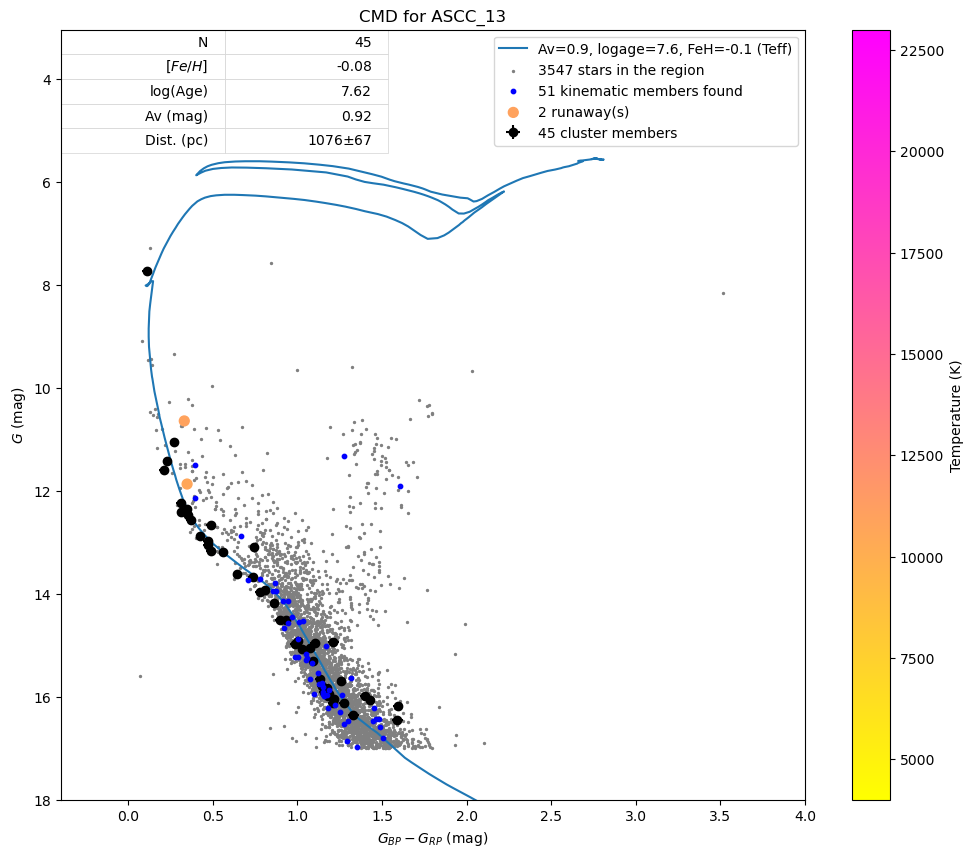

In [23]:
%run runaway_functionsv3

cl = Cluster("ASCC_13")
# cl.members()
# cl.runaways(temp_threshold=7000)
# cl.runaways()
plot_cmd(cl)
# cl.plot_traceback_clean()

getting from /home/surodeep/suro_aiu/traceback/cluster_runaway3d/
getting from /home/surodeep/suro_aiu/traceback/cluster_runaway3d/
getting from /home/surodeep/suro_aiu/traceback/cluster_runaway3d/
getting from /home/surodeep/suro_aiu/traceback/cluster_runaway3d/


<Figure size 640x480 with 0 Axes>

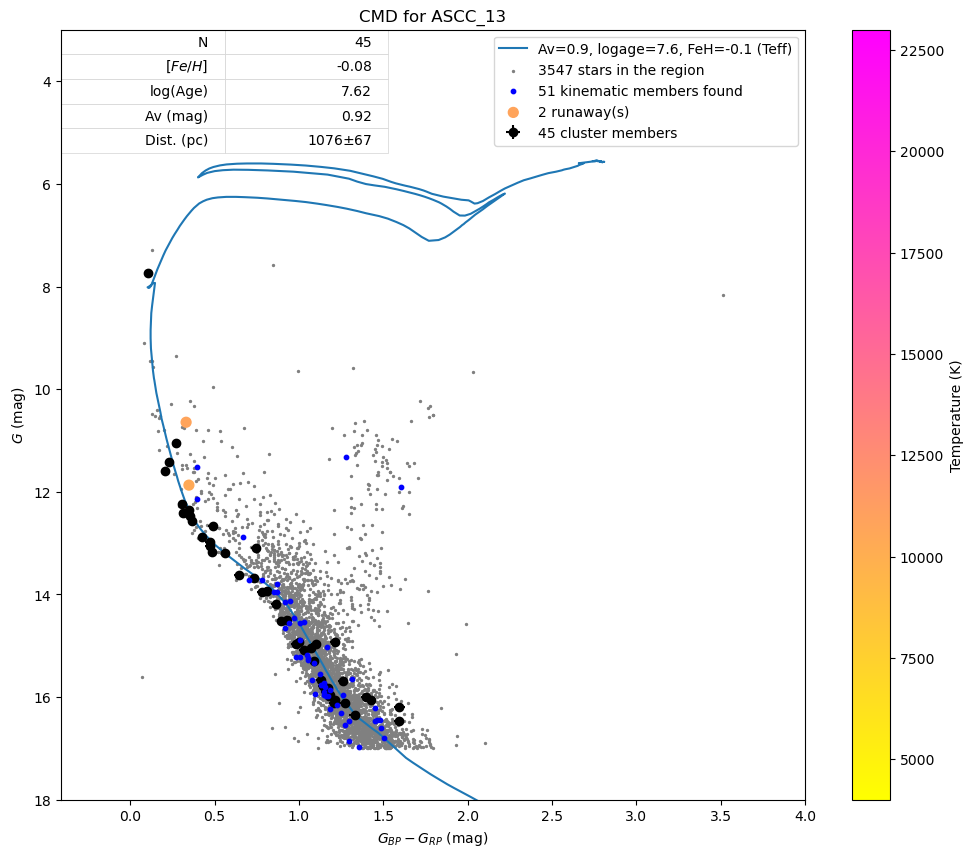

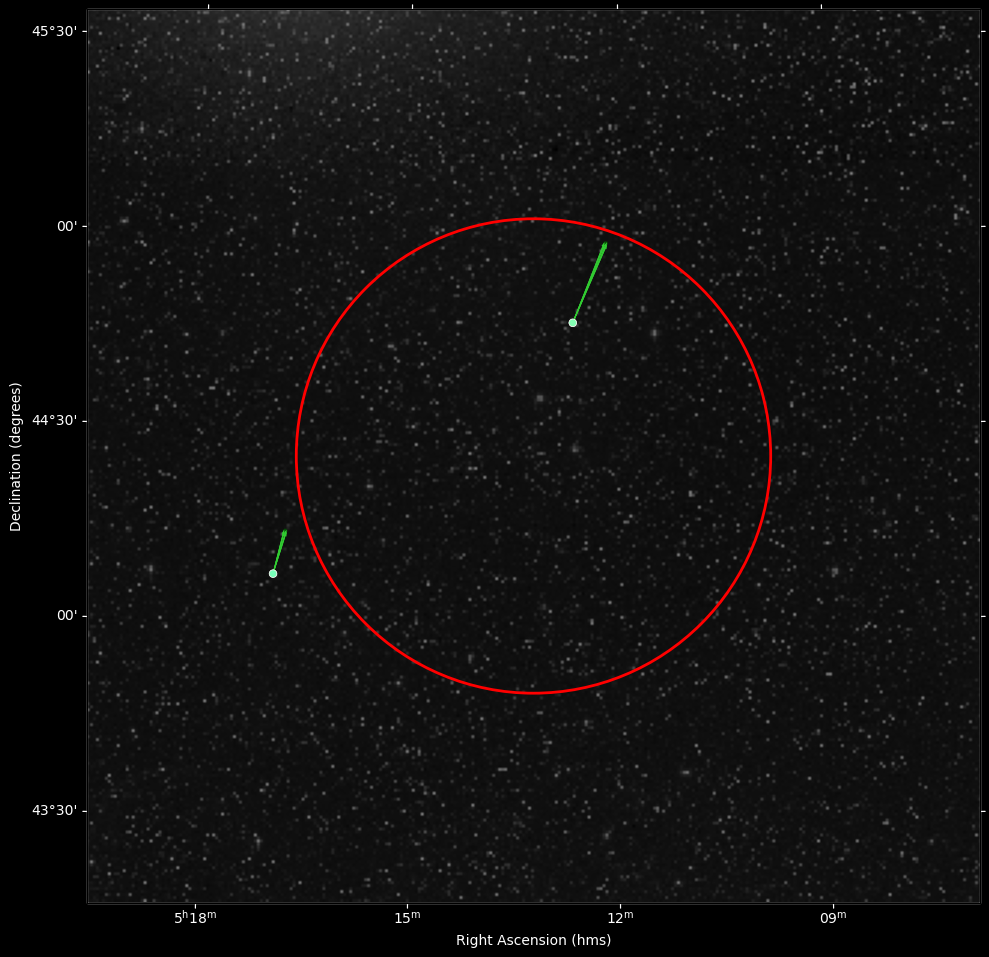

In [44]:
# cl = Cluster("IC_1396")
# np.count_nonzero(~cl.stars_in_region()['RV'].mask)
plot_cmd(cl)
cl.plot_traceback_clean()


AttributeError: 'list' object attribute 'append' is read-only

In [36]:
cl.runaways()

RA_ICRS_1,DE_ICRS_1,rgeo,Teff,Temp. Est,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Gmag,BP-RP,BPmag,RPmag,b_rgeo,B_rgeo,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,e_rmRA,rmDE,e_rmDE,v_pec,logg,RV,e_RV,rRV,e_rRV,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,v_pec3d
deg,deg,pc,K,K,mas,mas,,,,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,mag,mag,pc,pc,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,km / s,log(cm.s**-2),km / s,km / s,km / s,km / s,,,,,,,,,km / s
float64,float64,float64,float64,float64,float64,float64,float64,int32,str11,int64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,SkyCoord,float64,float32,float64,float32,float64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,str1,str1,float64
325.51669765696,57.65457941675,856.17932100,--,15830.0,0.0097,0.0101,25.4235,--,3975-390-1,2178485516524893824,1.1149,0.0110,1.266,-2.166,0.013,0.013,0.901,11.821659,0.492003,12.000584,11.508580,848.33752400,863.10577400,0.002759,0.002855,0.003794,0.006649,"325.51669765696,57.65457941675,856.179321",3.653052536010742,0.41091076,2.431177028656006,0.41091076,17.808179015111083,--,-35.00,13.11,-20.37,14.78,351789.83489,43.31,2.164e+05,120.7,1.976e+05,60.03,--,--,39.27
325.10326835067,57.46258397353,993.25323500,--,15830.0,0.0172,0.0171,13.0681,--,3975-644-1,2178383158871435392,0.9887,0.0184,-3.550,3.006,0.022,0.020,0.862,10.478822,0.485828,10.650633,10.164804,971.00061000,1010.93262000,0.002773,0.002837,0.003793,0.006631,"325.10326835067,57.46258397353,993.253235",-1.1629474639892576,0.41991073,7.603177028656006,0.41791075,36.212220577025626,--,-45.72,3.48,-31.09,5.15,1211763.53144,351.4,7.502e+05,356.2,6.811e+05,204.9,--,--,58.32


In [22]:

%run runaway_functionsv3
cl = Cluster("ASCC_107")
cl.stars_in_region()
t = cl.mymembers
t = cl.stars_in_region()
t = find_cluster(cl.stars_in_region(), sigma=1.5)

np.mean(t['RV']),np.sqrt(np.sum(t['e_RV'])**2/(len(t))**2),(np.count_nonzero(~(t['RV'].mask)))

(-5.870175438596491, 3.336015055950423, 57)

In [53]:
cl.all

Cluster,RA_ICRS,DE_ICRS,r50,N,pmRA,e_pmRA,pmDE,e_pmDE,Plx,e_Plx,RV,e_RV,NRV,Dist,e_Dist,logage,e_logage,__Fe_H_,e__Fe_H_,Av,e_Av,FileName,SimbadName,_RA.icrs,_DE.icrs
,deg,deg,deg,,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,,pc,pc,log(yr),log(yr),,,mag,mag,,,deg,deg
str17,float64,float64,float32,int16,float32,float32,float32,float32,float32,float32,float64,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,str31,str31,float64,float64
Basel_8,98.5582,8.0381,0.299,8,-0.190,0.225,-2.183,0.225,0.653,0.027,26.437,1.331,35,1450,49,7.671,0.236,0.028,0.064,1.083,0.079,clusters1/Basel_8.dat,Cl Basel 8,98.5582,8.0381


In [18]:
cl.kinematic_cluster

RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,e_rmRA,e_rmDE,rRV,e_rRV,Temp. Est
deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s,
float64,float64,float64,float64,float64,int32,str11,int64,float64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,str1,str1,float64,float32,float32,float32,SkyCoord,float64,float64,float32,float32,float64,float32,int64
297.17084324992,21.98476752483,0.0182,0.0199,1.4220,97471,1627-332-1,1827560055337367296,905.13012700,1.0861,0.0281,0.115,-5.226,0.024,0.026,0.972,18863.6,3.4733,8.152393,0.281548,8.234911,7.953362,--,--,883.81189000,929.28149400,10327361.03773,3664,6.942e+06,5500,5.222e+06,3230,--,--,0.002782,0.00292,0.003839,0.006758,"297.17084324992,21.98476752483,905.130127",0.30682609021663665,-0.0668694267272949,0.13751926,0.13951926,--,--,0
297.11085896723,21.96246797013,0.0365,0.0388,3.9200,--,1627-11-1,1827554282901324032,929.58429000,1.0677,0.0542,-0.429,-5.290,0.050,0.050,2.939,16531.8,3.8265,9.317932,0.302243,9.410587,9.108344,--,--,877.12780800,979.60638400,3529993.54319,998.6,2.351e+06,1625,1.802e+06,855.7,--,--,0.002772,0.002889,0.003814,0.006704,"297.11085896723,21.96246797013,929.58429",-0.23717390978336333,-0.13086942672729496,0.16351926,0.16351926,--,--,0
297.10135591695,21.91424698051,0.0116,0.0137,6.5227,--,1627-790-1,1827553496963958144,859.21020500,1.1238,0.0186,0.014,-5.148,0.016,0.017,0.946,11621.6,3.9140,11.037607,0.443225,11.193063,10.749838,-27.00,12.06,846.32116700,872.17327900,724275.30768,193.6,4.552e+05,219.1,3.974e+05,99.14,--,--,0.002771,0.002839,0.003789,0.006628,"297.10135591695,21.91424698051,859.210205",0.20582609021663667,0.01113057327270539,0.12951925,0.13051926,-21.13,15.40,0
296.82257860134,22.11386915659,0.0114,0.0121,19.9478,--,1627-1658-1,1827572321763952128,916.31494100,1.0526,0.0156,1.317,-4.259,0.015,0.016,0.907,10818.1,3.8842,11.066307,0.717512,11.336892,10.619380,-4.68,6.24,905.36102300,927.64782700,705381.56671,119.3,3.987e+05,209.6,4.481e+05,102.3,--,--,0.002761,0.002848,0.003787,0.006635,"296.82257860134,22.11386915659,916.314941",1.5088260902166366,0.9001305732727047,0.12851925,0.12951925,1.19,9.58,0
297.20914586998,21.78557955990,0.0170,0.0200,13.5450,--,1627-970-1,1827501785569485952,855.90472400,1.1426,0.0254,-1.889,-4.495,0.022,0.026,1.306,5062.0,2.8506,11.113397,1.603019,11.871234,10.268215,-1.71,0.23,836.92456100,874.39117400,675442.14013,207.2,2.437e+05,130.7,6.193e+05,273.6,--,--,0.002775,0.00285,0.00381,0.00666,"297.20914586998,21.7855795599,855.904724",-1.6971739097833634,0.664130573272705,0.13551927,0.13951926,4.16,3.57,0
296.99981774609,21.96166082885,0.0108,0.0119,9.4427,--,1627-1347-1,1827566484946171136,901.64007600,1.0658,0.0166,-0.200,-5.188,0.014,0.015,0.871,11839.5,4.0590,11.115017,0.482429,11.287463,10.805035,--,--,887.90368700,915.95544400,674435.06419,158.4,4.173e+05,205.7,3.777e+05,107.8,--,--,0.002767,0.002841,0.003792,0.006633,"296.99981774609,21.96166082885,901.640076",-0.008173909783363353,-0.028869426727294645,0.12751926,0.12851925,--,--,0
297.23011232398,21.89114185616,0.0092,0.0120,7.9152,--,1627-880-1,1827555730347495936,855.31518600,1.1190,0.0149,-0.156,-5.183,0.013,0.016,0.867,--,--,11.681152,0.626036,11.914623,11.288588,--,--,843.56378200,868.81396500,400392.32588,70.59,2.342e+05,122.1,2.42e+05,64.14,--,--,0.002762,0.002847,0.00379,0.006637,"297.23011232398,21.89114185616,855.315186",0.03582609021663666,-0.02386942672729475,0.12651926,0.12951925,--,--,0
297.07444806332,22.00880815725,0.0086,0.0086,4.8884,--,1627-149-1,1827555421109423360,

In [17]:
%run runaway_functionsv3
%matplotlib qt
cl = Cluster("ASCC_107")
# cir = find_cluster(cl.stars_in_region())


cl.plot_traceback_clean(star_tables=[cl.kinematic_cluster, 
                                    #  cir2
                                     ])

qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


In [45]:
cir

RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,e_rmRA,e_rmDE,rRV,e_rRV,Temp. Est
deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s,
float64,float64,float64,float64,float64,int32,str11,int64,float64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,str1,str1,float64,float32,float32,float32,SkyCoord,float64,float64,float32,float32,float64,float32,int64
339.84392032630,59.00715291679,0.0293,0.0308,0.2402,--,3995-625-1,2008383302396655488,2630.22485000,0.3652,0.0363,-2.873,-2.301,0.038,0.038,3.035,18135.5,3.3302,9.473729,0.937676,9.843719,8.906042,--,--,2393.19263000,2940.37549000,3058125.18769,951.5,1.577e+06,1154,2.171e+06,1124,--,--,0.002776,0.002901,0.003821,0.006722,"339.8439203263,59.00715291679,2630.22485",-0.1396428089141848,-0.41682148075103775,0.13697915,0.13697915,--,--,0
339.82384023875,59.01681945374,0.0097,0.0105,1.0890,--,3995-1075-1,2008430237808841600,2657.56860000,0.3583,0.0125,-2.747,-1.911,0.013,0.013,0.986,--,--,9.840384,0.868947,10.178231,9.309284,--,--,2587.60059000,2734.51587000,2181691.83228,1048,1.159e+06,1141,1.498e+06,1215,--,--,0.002804,0.002988,0.003881,0.006869,"339.82384023875,59.01681945374,2657.5686",-0.013642808914184457,-0.02682148075103763,0.11197916,0.11197916,--,--,0
340.10268328507,58.97390297864,0.0097,0.0107,8.0278,--,3996-1228-1,2008380794144211712,2570.86328000,0.3525,0.0122,-2.679,-1.930,0.013,0.014,0.903,--,--,11.482301,1.201067,11.985507,10.784440,--,--,2498.03125000,2653.16870000,480868.62054,798.2,2.194e+05,725.5,3.849e+05,2491,--,--,0.003292,0.004547,0.007978,0.01253,"340.10268328507,58.97390297864,2570.86328",0.054357191085815604,-0.045821480751037535,0.11197916,0.11297915,--,--,0
339.82166004461,59.00297803329,0.0089,0.0097,0.8784,--,--,2008430203449108224,2525.15747000,0.3648,0.0114,-2.953,-1.724,0.012,0.012,0.988,--,--,13.262117,0.961862,13.648018,12.686156,--,--,2459.89844000,2592.30542000,93346.90312,21.67,4.745e+04,60.24,6.679e+04,44.71,--,--,0.002767,0.003112,0.003849,0.006961,"339.82166004461,59.00297803329,2525.15747",-0.21964280891418442,0.16017851924896243,0.110979155,0.110979155,--,--,0
340.13166575232,58.80702105155,0.0325,0.0335,14.7229,--,--,2008366363053930112,2452.92578000,0.3907,0.0404,-2.667,-1.648,0.044,0.042,2.897,14207.5,3.6701,13.919951,1.094469,14.357768,13.263299,--,--,2208.02368000,2667.27612000,50929.10304,22.21,2.468e+04,22.44,3.925e+04,18.26,--,--,0.002796,0.00296,0.003813,0.006773,"340.13166575232,58.80702105155,2452.92578",0.06635719108581561,0.2361785192489625,0.14297915,0.14097916,--,--,0
340.05588361488,58.81770320410,0.0127,0.0133,12.9026,--,--,2008366981529199616,2631.17554000,0.3528,0.0158,-2.707,-2.076,0.017,0.016,1.080,9669.0,3.6676,14.161031,0.952089,14.543823,13.591734,--,--,2517.38721000,2756.26270000,40788.17956,8.078,2.079e+04,16.83,2.9e+04,14.29,--,--,0.002764,0.002925,0.003817,0.006742,"340.05588361488,58.8177032041,2631.17554",0.02635719108581558,-0.19182148075103767,0.11597915,0.114979155,--,--,0
339.84074866849,59.00514934930,0.0134,0.0139,0.2851,--,--,2008383302404812544,2604.80005000,0.3569,0.0163,-2.626,-1.913,0.018,0.017,1.124,11638.8,3.8049,14.199184,1.058014,14.629308,13.571294,--,--,2466.69116000,2720.19312000,39379.74224,11.71,1.922e+04,51.21,2.956e+04,27.21,--,--,0.002774,0.00402,0.003909,0.007929,"339.84074866849,59.0051493493,2604.80005",0.10735719108581554,-0.02882148075103763,0.11697915,0.11597915,--,--,0
339.85983016055,59.00845000045,0.0134,0.0137,0.3836,--,--,2008384779873564032,2623.42310000,0.3563,0.0168,-2.780,-1.834,0.017,0.016,1.021,10857.

In [36]:
%run runaway_functionsv3
%matplotlib qt
cl = Cluster("Berkeley_97")
cld = ClusterDias("Berkeley_97")
isochrone1 = Isochrone(cld)
isochrone2 = Isochrone(cl, Av=3, logage=7)
plot_cmd(cl, isochrones=[isochrone1,isochrone2])
# plot_cmd(cld)



In [48]:
source = 2008384504995669248
object = f"gaia dr3 {source}"
print(object, type(object))
Simbad.query_object("gaia dr3 2008383302396655488")

gaia dr3 2008384504995669248 <class 'str'>


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
HD 240016,22 39 22.5468,+59 00 25.787,14,14,0.029,0.031,90,A,O,2020yCat.1350....0G,1


In [45]:
cl.runaways()

RA_ICRS_1,DE_ICRS_1,rgeo,Teff,Temp. Est,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Gmag,BP-RP,BPmag,RPmag,b_rgeo,B_rgeo,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,v_pec,logg,RV,e_RV,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6
deg,deg,pc,K,K,mas,mas,,,,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,mag,mag,pc,pc,,,,,"deg,deg,pc",mas / yr,mas / yr,km / s,log(cm.s**-2),km / s,km / s,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,int32,str11,int64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,SkyCoord,float64,float64,float64,float64,float64,float32,float64,float32,float32,float32,float32,float32,str1,str1
339.89581711423,58.99547917199,2620.36230000,9168.0,10920.0,0.0202,0.0197,1.5205,--,--,2008384504995669248,0.3560,0.0241,-0.379,-1.352,0.025,0.024,1.086,15.384143,1.182070,15.883185,14.701116,2461.53345000,2759.61401000,0.00277,0.003852,0.004229,0.008081,"339.89581711423,58.99547917199,2620.3623",2.3543571910858154,0.5321785192489623,29.98008203419036,3.7061,--,--,13221.76503,3.482,6055,14.81,1.044e+04,18.25,--,--


In [44]:
for runaway in cl.runaways():
    source = runaway['Source']
    print(source)
    
    t = Simbad.query_object(f"gaia dr3 {source}")['MAIN_ID']
    print(t)

2008384504995669248


/usr/lib/python3/dist-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR3 2008384504995669248
  warnings.warn("Warning: The script line number %i raised "


TypeError: 'NoneType' object is not subscriptable

In [41]:
from astroquery.simbad import Simbad
t = Simbad.query_object("gaia dr3 2008384504995669248")
t

/usr/lib/python3/dist-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR3 2008384504995669248
  warnings.warn("Warning: The script line number %i raised "


In [13]:
dias2021 = Table.read("dias2021.tsv", format="ascii.ecsv")
maskplx = dias2021['Plx'] > 0.3
maskage = dias2021['logage'] < 7.7
workclusters = []
for clustername in dias2021[maskplx & maskage][:]['Cluster']:
    if clustername not in ['ASCC_79','BH_164','BH_23','Collinder_135','Collinder_140','Gulliver_9','IC_2391','IC_2602','Mamajek_1','Platais_8','UPK_535','UPK_606','UPK_640','Berkeley_59','COIN-Gaia_37','Ivanov_4','LP_1937','Sigma_Ori','UBC_632']:
        workclusters.append(clustername)
        # print(clustername)
        # cl = Cluster(clustername)
        # cl.prepare_trace()
# cl.stars_in_region()
# cl.stars_in_region()

In [ ]:
workclusters_mask = [cluster in workclusters for cluster in dias2021['Cluster']]
workclusterstable = dias2021[workclusters_mask]

rvexists = workclusterstable['RV'].mask
nrvgood = workclusterstable['NRV'] > 4

workclusterstable[~rvexists & nrvgood]

In [ ]:
def runaways_from(clustername):
    cl = Cluster(clustername)
    fs4giesler = cl.fast_stars_in_region()
    outputs = os.listdir(f"/home/surodeep/suro_aiu/traceback/cluster_runaway/{cl.name}/runaways/")
    linenos = []
    for output in outputs:
        #print(output)
        if 'run' in output:
            linenos.append(int(output.split("+")[1].replace(".out","")))
    linenos.sort()
    # print(linenos)
    i=np.array(linenos)-3
    def source_of(lineno, input_table):
        return input_table[lineno-2]['Source']
    return fs4giesler[i]
for cluster in workclusters:
    t = runaways_from(cluster)[runaways_from(cluster)['Teff'].argmax()]['Teff']
    
    if t>10000:
        print(cluster, t,runaways_from(cluster)[runaways_from(cluster)['Teff'].argmax()]['Source'])